# Análisis del transitorio de un circuito RCL Sobre amortiguado

En este tutorial analizo los datos adquiridos de un circuito **RLC transitorio SOBRE amortiguado**.

El circuito tiene las siguientes características:

```
 _____ -V0 (PULSE)+ _____ R _____ L _____ C ____   
|                     |               |         |  
GND                  Vin              VC        GND
```

Parámetros:
- R = 1000 $\Omega$
- L = 10 $m H$ (res. int. dedida $R_L=100 \Omega$)
- C = 2 $\mu F$

- Tiempo característico $\tau = \frac{2 L}{R - \sqrt{ R^2 - 4L/C }} \approx 2$ msec
- $V_0$ tren de pulsos cuadrados, tension en alto $5V$. Frecuencia fuente $f \approx \frac{1}{20 \tau}$
- En $V_{in}$ se mide la señal de entrada respecto de GND (masa) (Res. int. gen. $r_G=50 \Omega$).
- En $V_C$ se mide la tensión en el capacitor respecto de GND (masa).

Empezamos importando las librerías necesarias:

In [99]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.optimize import curve_fit

Cargamos los datos:

In [100]:
df = pd.read_csv("datos/data_RLC_sobre.csv")

df.head()

,time,Vin,VC,I
0,1.000000e-12,5.001241,0.005131,5.785584e-07
1,1.006218e-07,4.990261,0.013048,-5.099792e-05
2,2.012426e-07,4.987353,-0.001276,-9.701468e-05
3,3.018634e-07,4.983754,0.004083,-1.486478e-04
4,4.024842e-07,5.004826,-0.007423,-1.947017e-04


Hacemos un plot exploratorio:

<Axes: xlabel='time'>

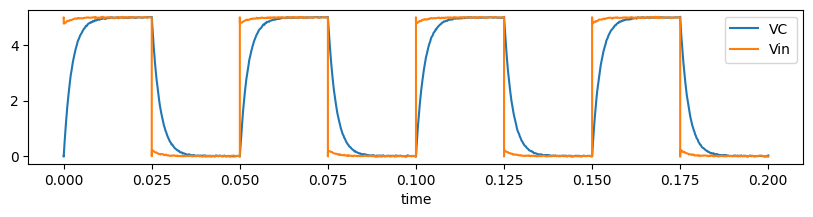

In [101]:
df.plot( x='time', y=['VC','Vin'], figsize=(10,2) )

Vamos a trabajar en mili segundos, defino la unidad temporal U,

<Axes: xlabel='t [msec]'>

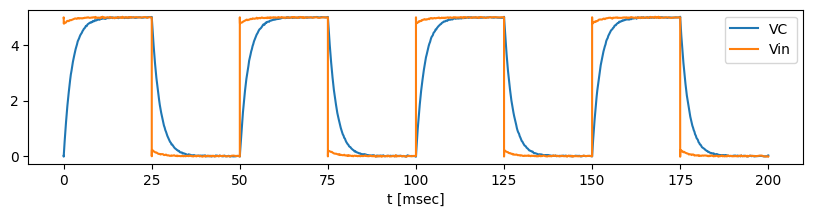

In [102]:
U = 1e-3

df["time"]/=U

df.plot( x='time', y=['VC','Vin'], figsize=(10,2), xlabel="t [msec]" )

**Filtramos** los datos para quedarnos solo con uno de transitorios. Nos quedamos con el que esta entre los tiempos 100 msec y 125 msec:

<Axes: xlabel='time'>

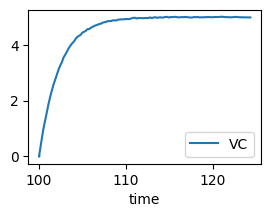

In [103]:
df_alto = df[ (df["time"]<125) & (df["time"]>100) ]

df_alto.plot(x='time', y='VC', figsize=(3,2))

El eje temporal esta trasladado, **llevamos el origen a cero** restando el primer punto, tambien pasamos nuestros datos a arrays de numpy para trabajar más cómodos el ajuste:

In [104]:
t0 = df_alto["time"].iloc[0]

t = df_alto["time"].to_numpy()-t0

VC = df_alto["VC"].to_numpy()

Definimos una **ecuación** para hacer el ajuste de la tensión que cae en los bornes del capacitor:

$$
V_C = V_0 \big( 1 -  \frac{ s_2 e^{s_1 t} - s_1 e^{s_2 t} }{s_2 - s_1} \big)
$$

In [105]:
def modelo_VC(u, V0, s1, s2):                         
    z= V0*( 1.0 - ( s2*np.exp(s1*u) - s1*np.exp(s2*u) )/( s2-s1 ) )
    return z


Estimamos los valores de los parámeros para pasarselos al algoritmo como **semillas**:

In [106]:
R= 1000+50+100
L= 10e-3
C= 2e-6

g = (R/(2.0*L))*U
w02 = (1.0/(L*C))*(U**2)

s1 = -g + np.sqrt( g**2 - w02 )
s2 = -g - np.sqrt( g**2 - w02 )

print (f"s1, amortig. lento (capacitor): {s1:.4f} [1/msec]")
print (f"s2, amortig. rápido (inductor): {s2:.4f} [1/msec]")

s1, amortig. lento (capacitor): -0.4364 [1/msec]
s2, amortig. rápido (inductor): -114.5636 [1/msec]


**Ajuste**:

In [107]:
# semillas (uso orden de magn. de los valores teóricos)
V0_ini = 10.0
s1_ini  = -0.5
s2_ini  = -110.0

popt, pcov = curve_fit(modelo_VC, t, VC, p0=[ V0_ini, s1_ini, s2_ini ] )      

V0, s1, s2 = popt

# Errores estandar
SE_V0, SE_s1, SE_s2 = np.sqrt(np.diag(pcov))

print ("Parámetros obtenidos del ajuste:")
print(f"V0 = ({V0:.4f} ± {SE_V0:.4f}) [V]")
print(f"s1 = ({s1:.4f} ± {SE_s1:.6f}) [1/msec]")
print(f"s2 = ({s2:.4f} ± {SE_s2:.6f}) [1/msec]")

Parámetros obtenidos del ajuste:
V0 = (4.9991 ± 0.0012) [V]
s1 = (-0.4361 ± 0.000681) [1/msec]
s2 = (-111.2027 ± 18.841501) [1/msec]


Vemos que el ajuste es un poco instable y el error de s2 es grande. Hacemos un **plot** con los datos del experimento y el ajuste:

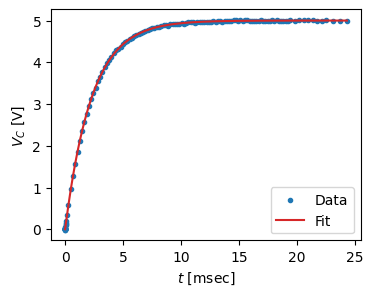

In [108]:
fig,ax = plt.subplots(figsize=(4,3))

ax.scatter( t, VC ,label='Data', marker='.')                                    # datos

ax.plot( t, modelo_VC(t, V0, s1, s2), c='C3', label='Fit' )       # modelo con parametros del ajuste

ax.set_xlabel("$t$ [msec]")
ax.set_ylabel("$V_C$ [V]")

plt.legend(loc=4)
plt.show()

### Inestabilidad del ajuste en casos donde $\gamma \gg \omega_0$

El ajuste da relativamente bien, pero con un error muy grande para s2 (~$20\%$). Además, si hacen la prueba se darán cuenta de que es muy sensible al valor de las semillas, el ajuste es numericamente inestable. Esto pasa por que el valor asociado al amortiguamiento rápido, s2, difiere en 2 ordenes de magnitud respecto al valor de s1. En otras palabras, el efecto del inductor en el transitorio transcurre en un tiempo muy corto, mientras que el efecto del capacitor domina toda la dinámica.

En [éste apunte](../../../Apuntes/2.Transitorio/3-1-Aprox%20caso%20RLC%20SobreAmortiguado.md) muestro que cuando $\gamma \gg \omega_0$, la curva del transitorio subamortiguado se puede aproximar a la curva de carga del capacitor,

$$
V_C(t) = V_0 (1 - e^{-\frac{t}{\tau_1}})
$$

$$
\tau_1 = RC
$$

Observad,

Parámetros obtenidos del ajuste:
V0 = (5.0000 ± 0.0014) [V]
tau1 = (2.3039 ± 0.003568) [msec]


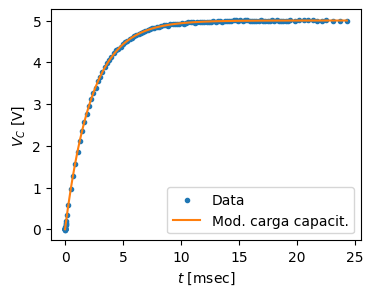

In [109]:
# defino modelo de carga
def modelo_carga_capacitor(t, V0, tau1):                         
    v= V0*( 1.0 - np.exp(-t/tau1) )
    return v

# semillas (uso orden de magn. de los valores teóricos)
V0_ini = 5
tau1_ini = (R*C)/U
p0 = [ V0_ini, tau1_ini ]

#ajuste
popt, pcov = curve_fit(modelo_carga_capacitor, t, VC, p0=p0 )      
V0, tau1 = popt

# Errores estandar
SE_V0, SE_tau1= np.sqrt(np.diag(pcov))

#parámetros
print ("Parámetros obtenidos del ajuste:")
print(f"V0 = ({V0:.4f} ± {SE_V0:.4f}) [V]")
print(f"tau1 = ({tau1:.4f} ± {SE_tau1:.6f}) [msec]")


fig,ax = plt.subplots(figsize=(4,3))

ax.scatter( t, VC ,label='Data', marker='.')  # datos

ax.plot( t, modelo_carga_capacitor(t, V0, tau1), c='C1', label='Mod. carga capacit.' ) 

ax.set_xlabel("$t$ [msec]")
ax.set_ylabel("$V_C$ [V]")

plt.legend(loc=4)
plt.show()


El ajuste es extraordinario, toda la dinámica la domina el capacitor. Notar que el valor de $s_1$ obtenido con el ajuste del otro modelo, se corresponde con $\frac{1}{\tau_1}$ obtenido con éste modelo (ver apunte para + info),

In [110]:
print ("Relación entre s1 y tau1: ")
print (f"s1 = {s1:.4f} [1/msec]")
print (f"1/tau1 = {1/tau1:.4f} [1/msec]")


Relación entre s1 y tau1: 
s1 = -0.4361 [1/msec]
1/tau1 = 0.4340 [1/msec]


Entonces, el procedimiento indicado para obtener un buen valor experimental del amortiguamiento $s_2$ a partir de un ajuste sin inestabilidad numérica, bajo la condición $\gamma \gg \omega_0$, es,

- 1) Ajustar usando el modelo de carga del capacitor para obtener el amortiguamiento s1 como 1/tau1.
- 2) Ajustar usando el modelo de trans. RLC sobre, **fijando s1 con el valor obtenido anteriormente** y dejando libre solo el parámetro s2.

Acontinuación, se testea el paso2

Parámetros obtenidos del ajuste:
s2 = (-152.4222 ± 29.7442) [1/msec]


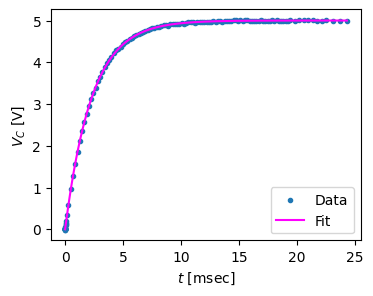

In [111]:
# modelo
def modelo_VC_reducido(u, s2):       
    
    # pars fijos
    V0=5.
    s1=-1.0/tau1

    v= V0*( 1.0 - ( s2*np.exp(s1*u) - s1*np.exp(s2*u) )/( s2-s1 ) )
    return v


# semillas (uso orden de magn. de los valores teóricos)
s2_ini  = -1.0

# ajuste
popt, pcov = curve_fit(modelo_VC_reducido, t, VC, p0=[ s2_ini ] )      
s2 = popt[0]

# Error estandar
SE_s2 = np.sqrt(np.diag(pcov))[0]

print ("Parámetros obtenidos del ajuste:")
print(f"s2 = ({s2:.4f} ± {SE_s2:.4f}) [1/msec]")


# plot
fig,ax = plt.subplots(figsize=(4,3))

ax.scatter( t, VC ,label='Data', marker='.')                                   

ax.plot( t, modelo_VC_reducido(t, s2), c='magenta', label='Fit' )  

ax.set_xlabel("$t$ [msec]")
ax.set_ylabel("$V_C$ [V]")

plt.legend(loc=4)
plt.show()

Si bien el error sigue siendo grande el 